# Pylops-distributed - Marchenko redatuming

### Author: M.Ravasi

This notebook extends the standard *Marchenko* algorithm in PyLops to distibuted computing with dask

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import dask.array as da
import zarr
import pylops
import pylops_distributed

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import cg, lsqr
from scipy.signal import convolve, filtfilt

from pylops.basicoperators import *
from pylops.waveeqprocessing.mdd       import MDC
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.waveeqprocessing.marchenko import directwave
from pylops.utils import dottest

from pylops_distributed.utils import dottest as ddottest
from pylops_distributed.basicoperators import Diagonal as dDiagonal
from pylops_distributed.basicoperators import Identity as dIdentity
from pylops_distributed.basicoperators import Roll as dRoll
from pylops_distributed.waveeqprocessing.mdd import MDC as dMDC
from pylops_distributed.waveeqprocessing.marchenko import Marchenko as dMarchenko
from pylops_distributed.optimization.cg import cg as dcg
from pylops_distributed.optimization.cg import cgls as dcgls

In [2]:
n_workers = 4
client = pylops_distributed.utils.backend.dask(processes=False, threads_per_worker=1,
                                               n_workers=n_workers)
client

Client Scheduler: inproc://10.0.0.37/4672/1 Dashboard: http://localhost:54777/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


In [3]:
#n_workers = 4
#client = pylops_distributed.utils.backend.dask(hardware='multi', client='be-linrgsn045:8786')
#client

## Inputs

Input parameters 

In [4]:
inputfile = '../data/marchenko/input.npz'
zarrfile = '../data/marchenko/input.zarr/'

vel = 2400.0        # velocity
toff = 0.045        # direct arrival time shift
nsmooth = 10        # time window smoothing 
nfmax = 500         # max frequency for MDC (#samples)
nstaper = 11        # source/receiver taper lenght
n_iter = 10         # iterations

jr = 1              # subsampling in r
js = 1              # subsampling in s

Load input

In [5]:
inputdata = np.load(inputfile)

Read and visualize geometry

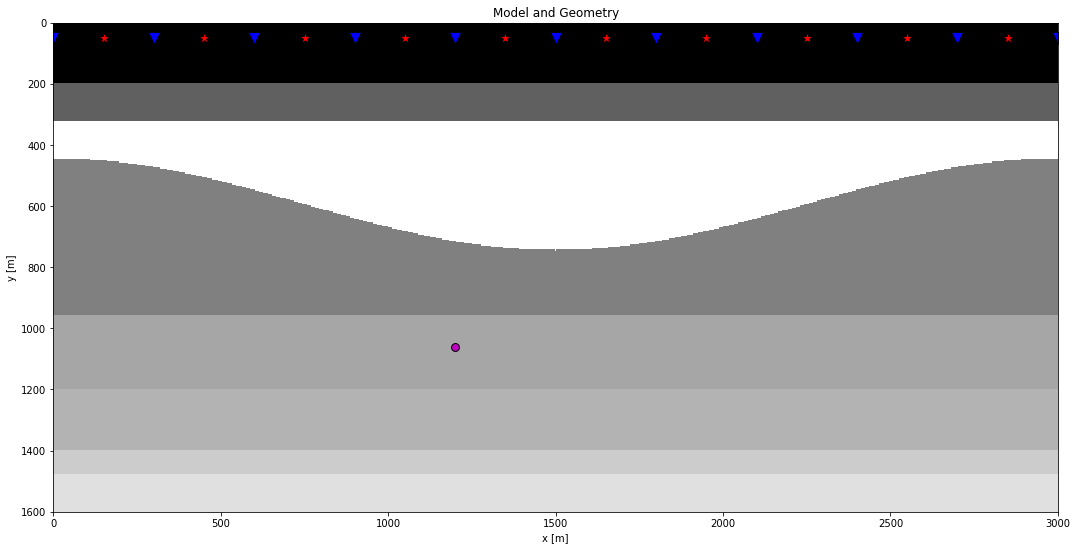

In [6]:
# Receivers
r = inputdata['r'][:,::jr]
nr = r.shape[1]
dr = r[0,1]-r[0,0]

# Sources
s = inputdata['s'][:,::js]
ns = s.shape[1]
ds = s[0,1]-s[0,0]

# Virtual points
vs = inputdata['vs']

# Density model
rho = inputdata['rho']
z, x = inputdata['z'], inputdata['x']

plt.figure(figsize=(18,9))
plt.imshow(rho, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(s[0, 5::10], s[1, 5::10], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(r[0, ::10],  r[1, ::10], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(vs[0], vs[1], marker='.', s=250, c='m', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1]);

Read data

In [7]:
# time axis
t = inputdata['t']
ot, dt, nt = t[0], t[1]-t[0], len(t)

# data
R = inputdata['R'][::js, ::jr]
R = np.swapaxes(R, 0, 1) # R[r, s, f] (for data with dipole source, you need to integrate over sources)

# tapering
taper = taper3d(nt, [ns, nr], [nstaper, nstaper], tapertype='hanning')
R = R*taper

Read subsurface fields and wavelet to apply to subsurface fields

In [8]:
Gsub = inputdata['Gsub'][:, ::jr]
G0sub = inputdata['G0sub'][:, ::jr]
wav = inputdata['wav']
wav_c = np.argmax(wav)

# convolve with wavelet
Gsub = np.apply_along_axis(convolve, 0, Gsub, wav, mode='full')
Gsub = Gsub[wav_c:][:nt]
G0sub = np.apply_along_axis(convolve, 0, G0sub, wav, mode='full') 
G0sub = G0sub[wav_c:][:nt]

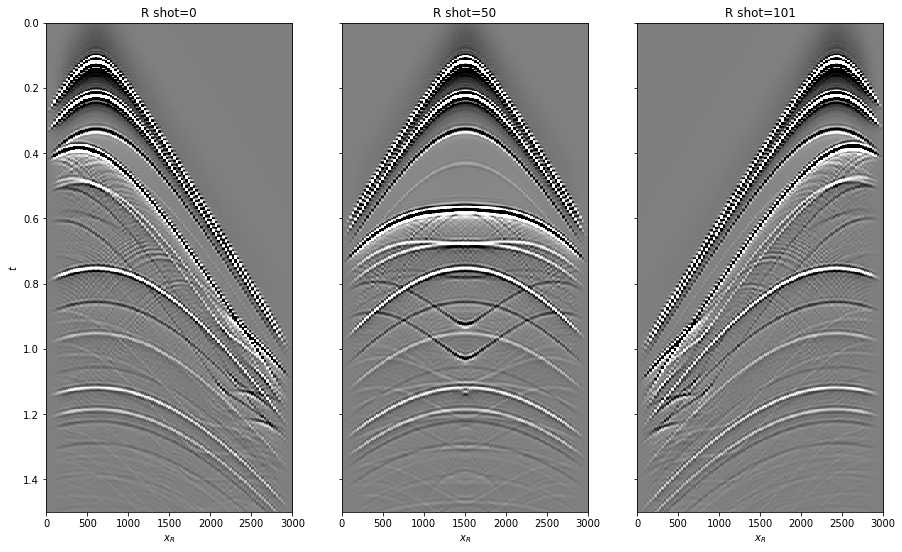

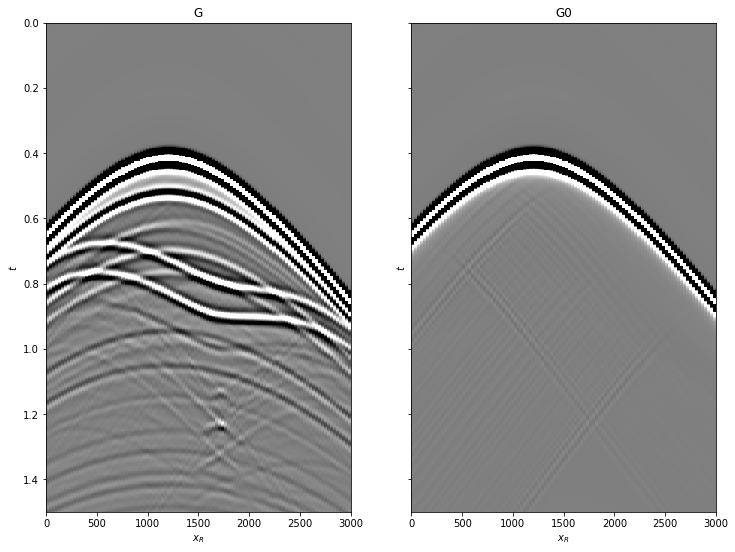

In [9]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 9))
axs[0].imshow(R[20].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title('R shot=0'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0)
axs[1].imshow(R[ns//2].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title('R shot=%d' %(ns//2)), axs[1].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0)
axs[2].imshow(R[-20].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[2].set_title('R shot=%d' %ns), axs[2].set_xlabel(r'$x_R$')
axs[2].axis('tight');
axs[2].set_ylim(1.5, 0)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 9))
axs[0].imshow(Gsub, cmap='gray', vmin=-1e5, vmax=1e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title('G'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0)
axs[1].imshow(G0sub, cmap='gray', vmin=-1e5, vmax=1e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title('G0'), axs[1].set_xlabel(r'$x_R$'), axs[1].set_ylabel(r'$t$')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0);

## Marchenko preparation

Create window

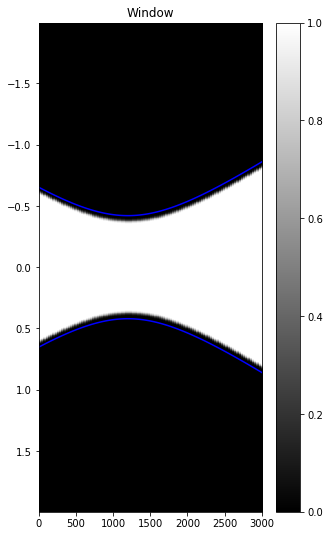

In [10]:
# direct arrival window - traveltime
directVS = np.sqrt((vs[0]-r[0])**2+(vs[1]-r[1])**2)/vel
directVS_off = directVS - toff

# window
idirectVS_off = np.round(directVS_off/dt).astype(np.int)
w = np.zeros((nr, nt))
for ir in range(nr):
    w[ir, :idirectVS_off[ir]]=1            
w = np.hstack((np.fliplr(w), w[:, 1:]))

if nsmooth>0:
    smooth=np.ones(nsmooth)/nsmooth
    w  = filtfilt(smooth, 1, w)    
    
fig, ax = plt.subplots(1, 1,  sharey=True, figsize=(5, 9))
im = ax.imshow(w.T, cmap='gray', extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax.plot(r[0], directVS,'b'),ax.plot(r[0], -directVS,'b')
ax.set_title('Window'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
ax.axis('tight')
fig.colorbar(im, ax=ax);

Create analytical direct wave

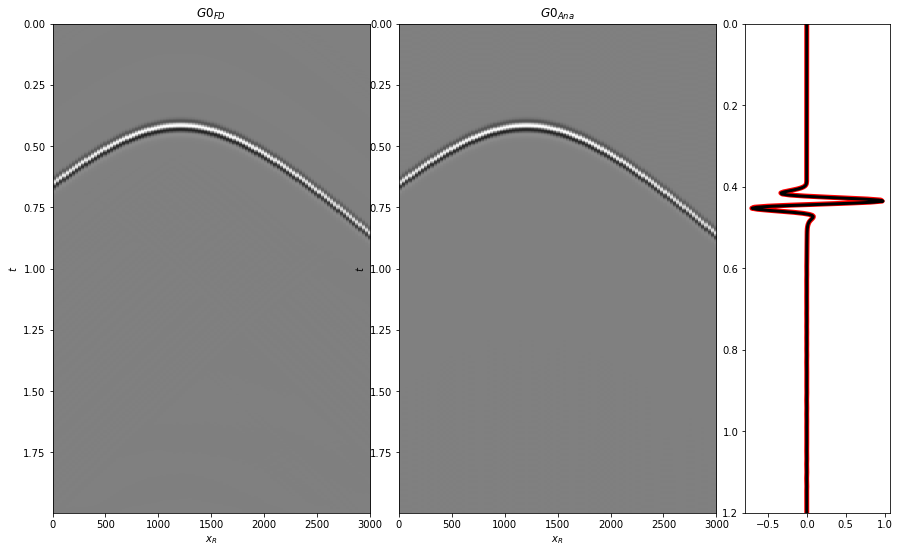

In [11]:
G0sub_ana = directwave(wav, directVS, nt, dt, nfft=2**11)

fig = plt.figure(figsize=(15,9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(G0sub/G0sub.max(), cmap='gray', vmin=-1, vmax=1, 
           extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax1.set_title(r'$G0_{FD}$'), ax1.set_xlabel(r'$x_R$'), ax1.set_ylabel(r'$t$')
ax1.axis('tight')
ax2.imshow(G0sub_ana/G0sub_ana.max(), cmap='gray', vmin=-1, vmax=1, 
           extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax2.set_title(r'$G0_{Ana}$'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax2.axis('tight')

ax3.plot(G0sub[:, nr//2]/G0sub.max(), t, 'r', lw=5)
ax3.plot(G0sub_ana[:, nr//2]/G0sub_ana.max(), t, 'k', lw=3)
ax3.set_ylim(1.2, 0);

For now we will use the direct wave obtained via finite-difference, but we will show later that Marchenko redatuming can converge to the correct solution also when using an analytical direct wave.

## Inversion

In [12]:
# Add negative time to operators
Rtwosided = np.concatenate((np.zeros((nr, ns, nt-1)), R), axis=-1)
Rtwosided_fft = np.fft.rfft(Rtwosided, 2*nt-1, axis=-1)/np.sqrt(2*nt-1)
Rtwosided_fft = Rtwosided_fft[...,:nfmax]
Rtwosided_fft = Rtwosided_fft.transpose(2, 0, 1) # R[f, r, s]

Convert ``Rtwosided_fft`` into dask, distributed over frequencies. In practice this will be done in pre-processing and here we will read it from Zarr file

In [13]:
dRtwosided_fft = da.from_array(Rtwosided_fft, chunks=(nfmax // n_workers, nr, ns))
dRtwosided_fft

dask.array<array, shape=(500, 101, 101), dtype=complex128, chunksize=(125, 101, 101)>

Alternatively we can read it directly from Zarr file created in ``Zarr.ipynb`` notebook

In [14]:
dRtwosided_fft = da.from_zarr(zarrfile)
dRtwosided_fft

dask.array<from-zarr, shape=(500, 101, 101), dtype=complex64, chunksize=(125, 101, 101)>

### Single point virtual source

In [15]:
MarchenkoWM = dMarchenko(dRtwosided_fft, nt=nt, dt=dt, dr=dr, 
                         wav=wav, toff=toff, nsmooth=nsmooth)

f1_inv_minus_f, f1_inv_plus_f, p0_minus_f, g_inv_minus_f, g_inv_plus_f = \
    MarchenkoWM.apply_onepoint(directVS, G0=G0sub.T, rtm=True, greens=True, 
                               dottest=True, **dict(niter=10, compute=True))
g_inv_tot_f = g_inv_minus_f + g_inv_plus_f

Dot test passed, v^T(Opu)=79215.441770 - u^T(Op^Tv)=79215.441770
Dot test passed, v^T(Opu)=20268.616609 - u^T(Op^Tv)=20268.616609


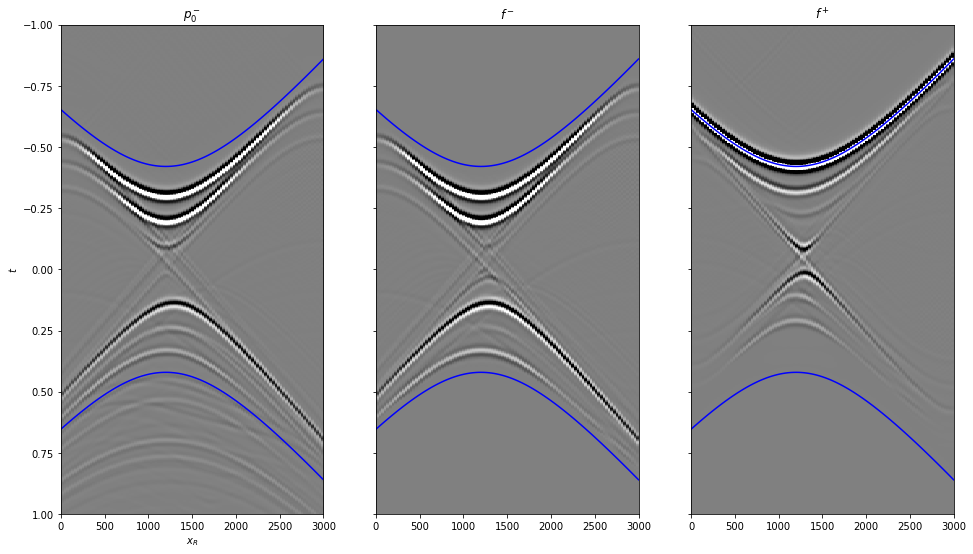

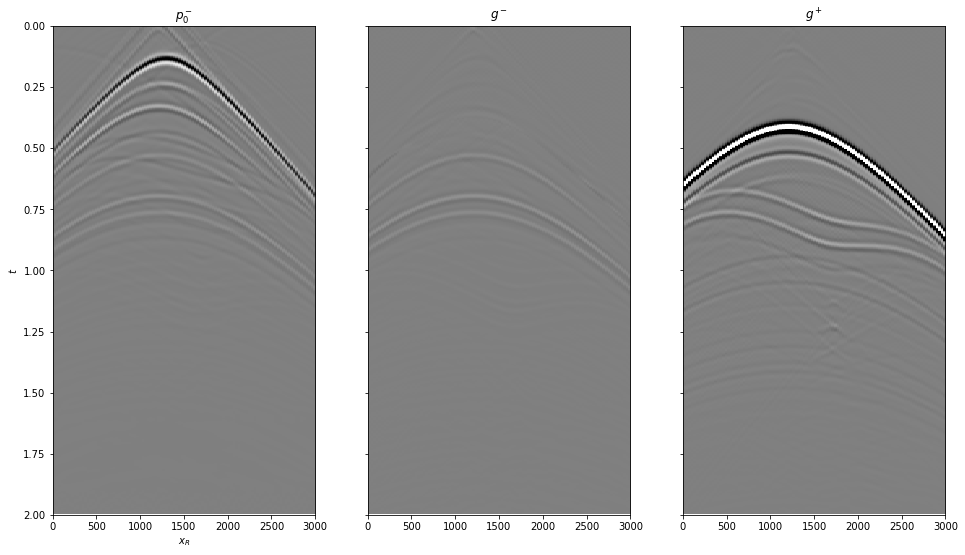

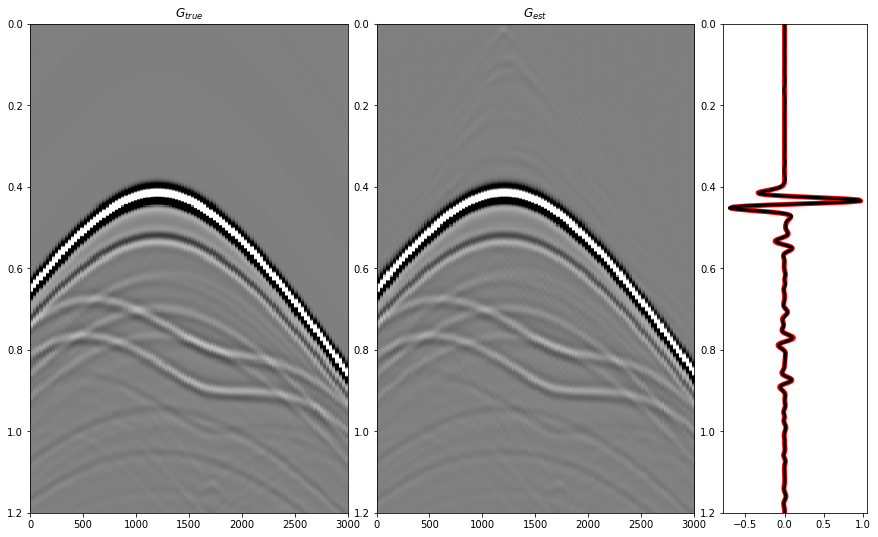

In [16]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(p0_minus_f.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].plot(r[0], directVS,'b'),axs[0].plot(r[0], -directVS,'b')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(f1_inv_minus_f.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f^-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].plot(r[0], directVS,'b'),axs[1].plot(r[0], -directVS,'b')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(f1_inv_plus_f.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f^+$'), axs[0].set_xlabel(r'$x_R$')
axs[2].plot(r[0], directVS,'b'),axs[2].plot(r[0], -directVS,'b')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(p0_minus_f.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(2, 0);
axs[1].imshow(g_inv_minus_f.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$g^-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(2, 0);
axs[2].imshow(g_inv_plus_f.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$g^+$'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(2, 0);

fig = plt.figure(figsize=(15,9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(Gsub, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax1.set_title(r'$G_{true}$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
ax1.axis('tight')
ax1.set_ylim(1.2, 0)
ax2.imshow(g_inv_tot_f.T, cmap='gray', vmin=-5e5, vmax=5e5, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax2.set_title(r'$G_{est}$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
ax2.axis('tight')
ax2.set_ylim(1.2, 0)

ax3.plot(Gsub[:, nr//2]/Gsub.max(), t, 'r', lw=5)
ax3.plot(g_inv_tot_f[nr//2, nt-1:]/g_inv_tot_f.max(), t, 'k', lw=3)
ax3.set_ylim(1.2, 0);

### Multiple points virtual source

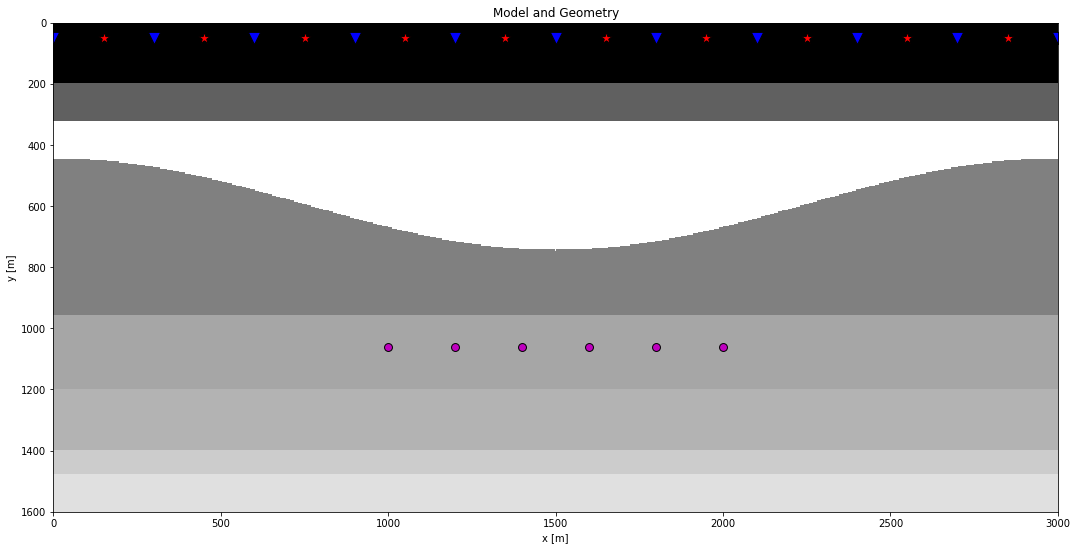

In [17]:
nvs = 6
vs = [np.arange(nvs)*200 + 1000, 
      np.ones(nvs)*1060]

plt.figure(figsize=(18,9))
plt.imshow(rho, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(s[0, 5::10], s[1, 5::10], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(r[0, ::10],  r[1, ::10], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(vs[0], vs[1], marker='.', s=250, c='m', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1]);

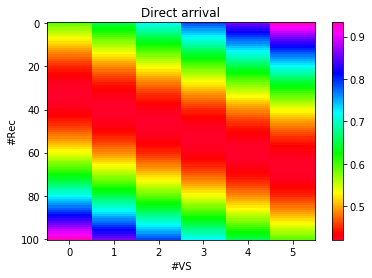

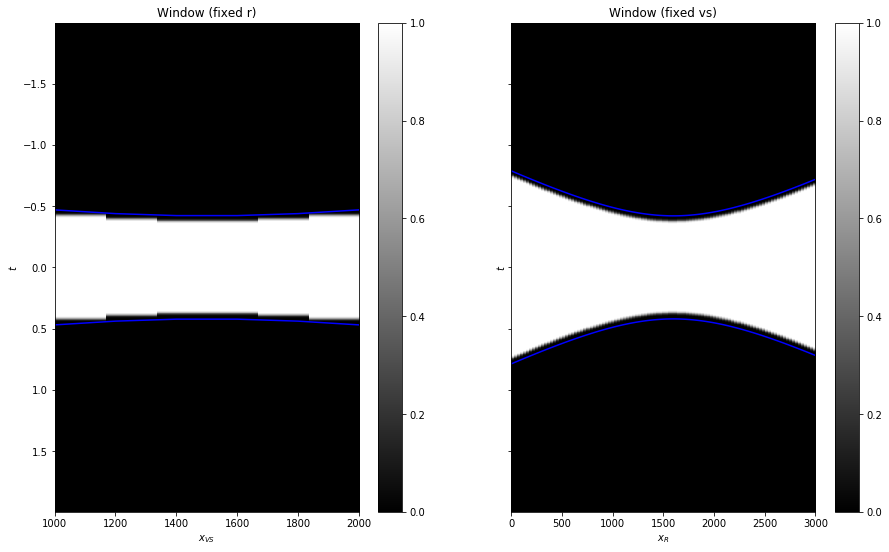

In [18]:
# direct arrival window - traveltime
directVS = np.sqrt((vs[0]-r[0][:, np.newaxis])**2+(vs[1]-r[1][:, np.newaxis])**2)/vel
directVS_off = directVS - toff

plt.figure()
im = plt.imshow(directVS, cmap='gist_rainbow')
plt.axis('tight')
plt.xlabel('#VS'),plt.ylabel('#Rec'),plt.title('Direct arrival')
plt.colorbar(im);

idirectVS_off = np.round(directVS_off/dt).astype(np.int)
w = np.zeros((nr, nvs, nt))
for ir in range(nr):
    for ivs in range(nvs):
        w[ir, ivs, :idirectVS_off[ir, ivs]]=1            
w = np.concatenate((np.flip(w, axis=-1), w[:,:, 1:]), axis=-1)

if nsmooth>0:
    smooth=np.ones(nsmooth)/nsmooth
    w  = filtfilt(smooth, 1, w)    

fig, axs = plt.subplots(1, 2,  sharey=True, figsize=(15, 9))
im = axs[0].imshow(w[nr//2].T, cmap='gray', extent=(vs[0][0], vs[0][-1], t[-1], -t[-1]))
axs[0].plot(vs[0], directVS[nr//2],'b'),axs[0].plot(vs[0], -directVS[nr//2],'b')
axs[0].set_title('Window (fixed r)'), axs[0].set_xlabel(r'$x_{VS}$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
fig.colorbar(im, ax=axs[0])
im = axs[1].imshow(w[:, nvs//2].T, cmap='gray', 
                   extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].plot(r[0], directVS[:, nvs//2],'b'),axs[1].plot(r[0], -directVS[:, nvs//2],'b')
axs[1].set_title('Window (fixed vs)'), axs[1].set_xlabel(r'$x_R$'), axs[1].set_ylabel(r'$t$')
axs[1].axis('tight')
fig.colorbar(im, ax=axs[1]);


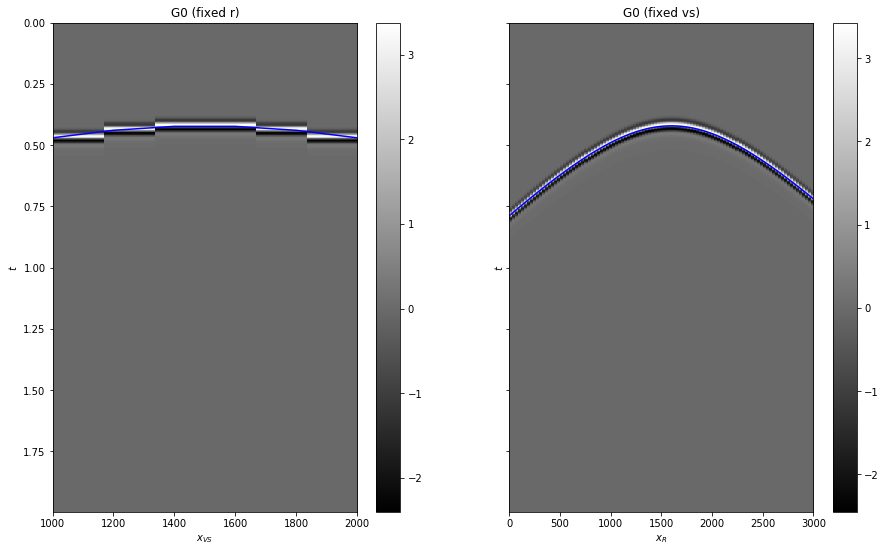

In [19]:
G0sub_ana = np.zeros((nr, nvs, nt))
for ivs in range(nvs):
    G0sub_ana[:, ivs] = directwave(wav, directVS[:,ivs], nt, dt, nfft=int(2**(np.ceil(np.log2(nt))))).T

fig, axs = plt.subplots(1, 2,  sharey=True, figsize=(15, 9))
im = axs[0].imshow(G0sub_ana[nr//2].T, cmap='gray', extent=(vs[0][0], vs[0][-1], t[-1], t[0]))
axs[0].plot(vs[0], directVS[nr//2],'b')
axs[0].set_title('G0 (fixed r)'), axs[0].set_xlabel(r'$x_{VS}$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
fig.colorbar(im, ax=axs[0])
im = axs[1].imshow(G0sub_ana[:,nvs//2].T, cmap='gray', extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].plot(r[0], directVS[:, nvs//2],'b')
axs[1].set_title('G0 (fixed vs)'), axs[1].set_xlabel(r'$x_R$'), axs[1].set_ylabel(r'$t$')
axs[1].axis('tight')
fig.colorbar(im, ax=axs[1]);

In [20]:
MarchenkoWM = dMarchenko(dRtwosided_fft, nt=nt, dt=dt, dr=dr, wav=wav,
                         toff=toff, nsmooth=nsmooth)

f1_inv_minus_f, f1_inv_plus_f, p0_minus_f, g_inv_minus_f, g_inv_plus_f = \
    MarchenkoWM.apply_multiplepoints(directVS, G0=G0sub_ana,  rtm=True, greens=True, 
                                     dottest=False, **dict(niter=10, compute=True))
g_inv_tot_f = g_inv_minus_f + g_inv_plus_f

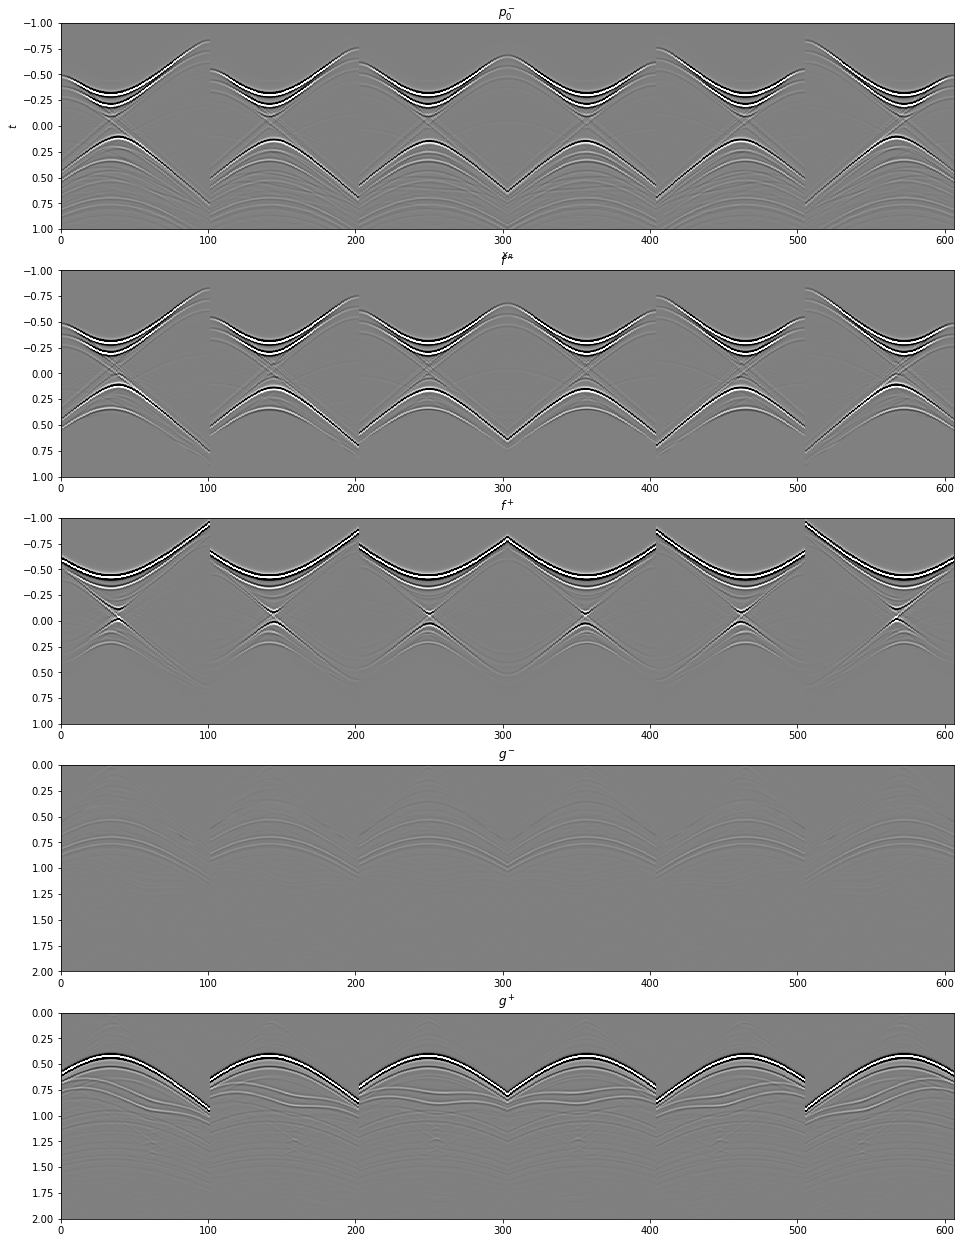

In [21]:
fig, axs = plt.subplots(5, 1, figsize=(16, 22))
axs[0].imshow(np.swapaxes(p0_minus_f, 0, 1).reshape(nr*nvs, 2*nt-1).T, cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(np.swapaxes(f1_inv_minus_f, 0, 1).reshape(nr*nvs,2*nt-1).T, cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[1].set_title(r'$f^-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(np.swapaxes(f1_inv_plus_f, 0, 1).reshape(nr*nvs,2*nt-1).T, cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[2].set_title(r'$f^+$'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);
axs[3].imshow(np.swapaxes(g_inv_minus_f, 0, 1).reshape(nr*nvs,2*nt-1).T, cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[3].set_title(r'$g^-$'), axs[0].set_xlabel(r'$x_R$')
axs[3].axis('tight')
axs[3].set_ylim(2, 0);
axs[4].imshow(np.swapaxes(g_inv_plus_f, 0, 1).reshape(nr*nvs,2*nt-1).T, cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[4].set_title(r'$g^+$'), axs[0].set_xlabel(r'$x_R$')
axs[4].axis('tight')
axs[4].set_ylim(2, 0);

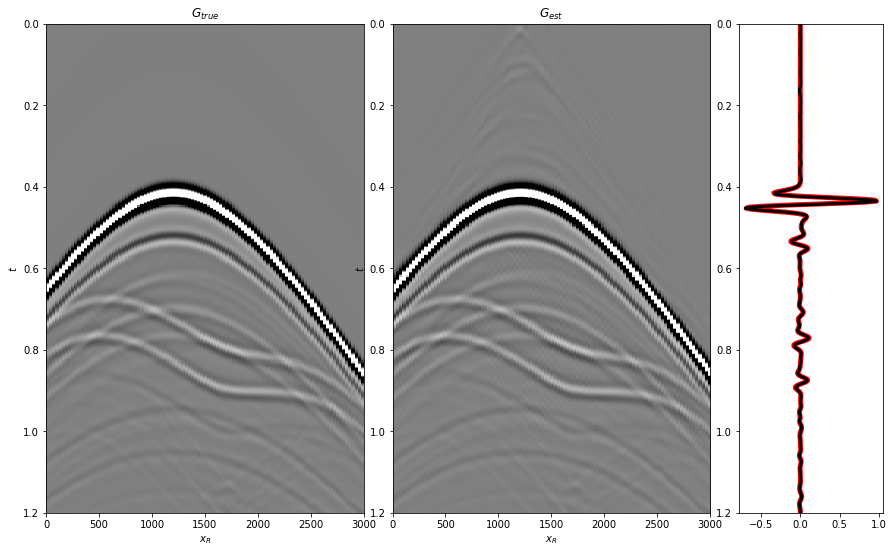

In [24]:
fig = plt.figure(figsize=(15,9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(Gsub, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax1.set_title(r'$G_{true}$'), ax1.set_xlabel(r'$x_R$'), ax1.set_ylabel(r'$t$')
ax1.axis('tight')
ax1.set_ylim(1.2, 0)
ax2.imshow(g_inv_tot_f[:, 1].T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax2.set_title(r'$G_{est}$'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax2.axis('tight')
ax2.set_ylim(1.2, 0)

ax3.plot(Gsub[:, nr//2]/Gsub.max(), t, 'r', lw=5)
ax3.plot(g_inv_tot_f[nr//2, 1, nt-1:]/g_inv_tot_f.max(), t, 'k', lw=3)
ax3.set_ylim(1.2, 0);